# A405 final problem

The cells below read in pres (hPa), hght (m), temp (C), dwpt (C) stored as a dataframe
in final_sounding.h5 dataframe 

For each question, insert a cell or cells that answers the question.  You are free to use any code in the github master branch, but double check before you hand in your notebook that it runs on a clean checkout of the
master branch (i.e. that you've included all your own code).

Hand in via email  (which may not work if the attachment is too big), or by sharing a dropbox-like url.

Due on Wednesday, April 20 at 9am.

Good luck, and don't hesitate to ask if anything is unclear.


In [95]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import h5py
import soundings
from pathlib import Path
from a405thermo.thermlib import find_thetaet, find_rsat, tinvert_thetae
from a405thermo.constants import constants as c
site = 'final_sounding.h5'
sounding_file = str(Path(soundings.__path__[0]) / site)
with pd.HDFStore(sounding_file) as store:
    for key in store:
        df_sounding=store[key]
print(df_sounding.head())

    pres   hght  temp  dwpt
0  991.0  172.0  23.2  19.2
1  988.0  198.0  22.8  18.8
2  941.6  610.0  19.0  15.0
3  925.0  762.0  17.6  13.6
4  908.5  914.0  16.3  13.3


# Problem 1

make a 2 column  plot of the temperature and dewpoint as a function height for
the bottom 8000 meters of the sounding

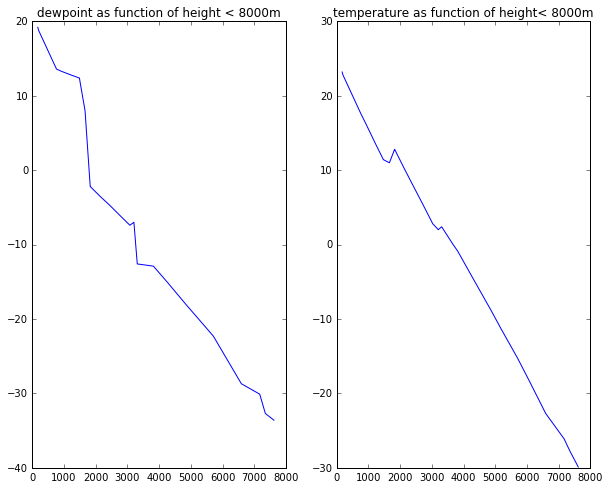

In [96]:
df_sound = df_sounding.copy()
below8000m_sond = df_sound[df_sound.hght<8001]
below8000m_hght = below8000m_sond['hght']
below8000m_dwpt = below8000m_sond['dwpt']
below8000m_temp = below8000m_sond['temp']
below8000m_pres = below8000m_sond['pres'] #hPa

%matplotlib inline
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,8))
ax1.plot(below8000m_hght,below8000m_dwpt)
ax1.set_title('dewpoint as function of height < 8000m')
ax2.plot(below8000m_hght,below8000m_temp)
ax2.set_title('temperature as function of height< 8000m')

# Problem 2

redraw your problem 1 figure, adding the moist adiabat for the lowest point (172 meters) 

In [97]:
# make interpolated arrays of height, pressure, dewpoint, temp

from scipy.interpolate import interp1d
reg_hght=np.linspace(172,7500,50)
   
hght_interp1= interp1d(below8000m_hght,below8000m_hght)
hght_interp = hght_interp1(reg_hght)
    
pres_interp1=interp1d(below8000m_hght,below8000m_pres)
pres_interp = pres_interp1(reg_hght)
    
env_temp_interp1=interp1d(below8000m_hght,below8000m_temp,bounds_error=False)
env_temp_interp = env_temp_interp1(reg_hght)
   
env_dwpt_interp1=interp1d(below8000m_hght,below8000m_dwpt,bounds_error=False)
env_dwpt_interp = env_dwpt_interp1(reg_hght)
    
print(np.size(hght_interp),'= size of interpolation')
    

50 = size of interpolation


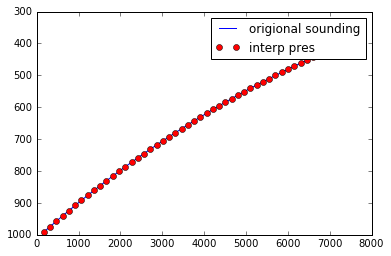

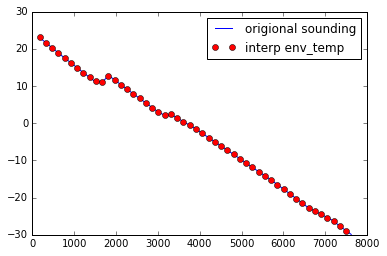

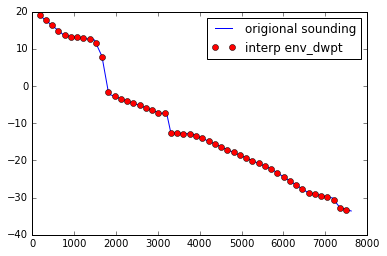

In [98]:
#sanity check that interpolations look ok

%matplotlib inline
fig,ax = plt.subplots(1,1)
ax.plot(below8000m_hght,below8000m_pres,label='origional sounding')
ax.invert_yaxis()
ax.plot(reg_hght,pres_interp,'ro',label='interp pres')
plt.legend()
    
fig,ax = plt.subplots(1,1)
ax.plot(below8000m_hght,below8000m_temp,label='origional sounding')
ax.plot(reg_hght,env_temp_interp,'ro',label='interp env_temp')
plt.legend()
    
fig,ax = plt.subplots(1,1)
ax.plot(below8000m_hght,below8000m_dwpt,label='origional sounding')
ax.plot(reg_hght,env_dwpt_interp,'ro',label='interp env_dwpt')
plt.legend()


In [99]:
from a405thermo.thermlib import find_lcl
from a405thermo.thermlib import find_Tmoist


# assume no loss due to precipitation (e.g NOT psuedo-adiabatic)

#starting point of dry adiabatic ascent at lowest point (172 meters):

temp_start = env_temp_interp[0] + c.Tc #K
dwpt_start = env_dwpt_interp[0] + c.Tc #K
hght_start = hght_interp[0] # m
pres_start = pres_interp[0] * 10**2 #Pa

# ascend dry adiabatically until LCL:
lcl = find_lcl(dwpt_start,temp_start,pres_start)

temp_lcl = lcl[0]
pres_lcl = lcl[1]
print(temp_lcl, 'temp_lcl')
print(pres_lcl, 'pres_lcl (Pa)') #Pa

r_sat_lcl = find_rsat(temp_lcl,pres_lcl)
print(r_sat_lcl, 'r_sat_lcl') #at LCL, rsat = r_total_lcl (total water mixing ratio)
r_total_lcl = r_sat_lcl
dwpt_lcl = temp_lcl
thetae = find_thetaet(dwpt_lcl, r_total_lcl,temp_lcl,pres_lcl)
print(thetae,'thetae')

# from LCL, ascend moist adiabatically
    # thetae is saturated adiabat ascent of moist air parcel


ind_interp = np.arange(np.size(pres_interp))
moist_adiabat_ycoords_interp =[]
for i in ind_interp:
    moist_adiabat_temps_interp = find_Tmoist(thetae,pres_interp[i]*100.) - c.Tc
    moist_adiabat_ycoords_interp.append(moist_adiabat_temps_interp)


291.396981378 temp_lcl
93397.864574 pres_lcl (Pa)
0.0142711708336 r_sat_lcl
335.660738988 thetae


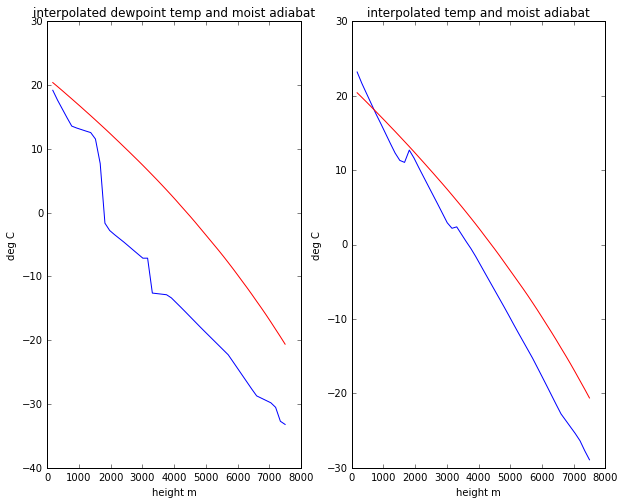

In [100]:
# plot moist adiabat
%matplotlib inline

fig1 = plt.figure(figsize=(10,8))
sub1 = fig1.add_subplot(1,2,1, xlabel='height m', ylabel= 'deg C')
plt.subplot(1,2,1, xlabel='height m', ylabel= 'deg C')
sub1.set_title('interpolated dewpoint temp and moist adiabat')
sub1.plot(hght_interp,env_dwpt_interp,'b',hght_interp,moist_adiabat_ycoords_interp,'r')

sub2 = fig1.add_subplot(1,2,2, xlabel='height m', ylabel= 'deg C')
plt.subplot(1,2,2, xlabel='height m', ylabel= 'deg C')
sub2.set_title('interpolated temp and moist adiabat')
sub2.plot(hght_interp,env_temp_interp,'b',hght_interp,moist_adiabat_ycoords_interp,'r')

plt.show()

# Problem 3

Write a function that takes as input the dataframe and a height, and finds rv, rl and the buoyancy at that
height.   Use it to calculate rv, rl and the buoyancy for air from 172 meters lifted to 4 km.


In [101]:
from a405thermo.thermlib import find_rvrl, find_Tv, find_buoy

def find_buoy_rvrl(df_sound, height):
    '''
    Function that computes the vapor and liquid water mixing ratios and the bouyancy 
    
    Parameters
    ----------
    df_sound: dataframe of the sounding
        df_sounding 
        the dataframe stored in final_sounding.h5 dataframe
        dataframe columns are:
            pres: (hPa) Pressure (float)
            hght: (m) Height (float)
            temp: (deg C) Temperature (float)
            dwpt: (deg C) Dewpoint (float)
    
    height: float (m)
    
    Returns
    -------
    
    rv: float
        water vapor mixing ratio (kg/kg)
    rl: float
        liquid water mixing ratio (kg/kg)
    bouy: float
        bouyancy (m/s/s)
    '''
    print(height, 'start height (m)')
    # Step 1: 
        # make interpolated array of height
        # ''    ''           ''   '' pressure
        # ''    ''           ''   '' dewpoint
        # ''    ''           ''   '' temperature
    
    from scipy.interpolate import interp1d
    reg_hght=np.linspace(172,7500,50)
   
    hght_interp1= interp1d(below8000m_hght,below8000m_hght)
    hght_interp = hght_interp1(reg_hght)
    
    pres_interp1=interp1d(below8000m_hght,below8000m_pres)
    pres_interp = pres_interp1(reg_hght)
    
    env_temp_interp1=interp1d(below8000m_hght,below8000m_temp,bounds_error=False)
    env_temp_interp = env_temp_interp1(reg_hght)
   
    env_dwpt_interp1=interp1d(below8000m_hght,below8000m_dwpt,bounds_error=False)
    env_dwpt_interp = env_dwpt_interp1(reg_hght)
    
    print(np.size(hght_interp),'size hght_interp')
    
    
    
    # Step 1: use searchdorted to find the indice of the input height in df
    indice = np.searchsorted(hght_interp, height)
    print(indice, 'indice of interpolation')
    
    # Step 2: for that index use:
    
    env_T = env_temp_interp[indice] + c.Tc #K
    print(env_T, 'env_T')
    
    env_pres = pres_interp[indice] * 100 #Pa
    print(env_pres, 'env_pres (Pa)')
    
    adia_Tv = moist_adiabat_ycoords_interp[indice] + c.Tc #K #adia_Tv is virtual temp of theparcel (from thetae adiabat)
    print(adia_Tv, 'adia_Tv')
    
    # step 3: calculate the rv, rl 
    rvrl_array = find_rvrl(env_T,r_total_lcl,env_pres)
    rv = rvrl_array[0]
    rl = rvrl_array[1]
    print(rv, 'rv')
    print(rl, 'rl')
    
    #step 4: calculate env_Tv
    env_Tv = find_Tv(env_T, rv, rl) # env_Tv is virtual temp of the environment (from sounding)
    print(env_Tv, 'env_Tv')
    
    # step 5:  find buoy
    buoy = find_buoy(adia_Tv, env_Tv) # m/s^2
    print(buoy, 'buoyancy')
    rv_rl_buoy = np.array([rv,rl,buoy])
    return rv_rl_buoy

    
find_buoy_rvrl(df_sound, 4000)   
  

4000 start height (m)
50 size hght_interp
26 indice of interpolation
270.422012966 env_T
61880.6136146 env_pres (Pa)
275.0858491596379 adia_Tv
0.0050698739138 rv
0.00920129691985 rl
268.786545158 env_Tv
0.229673621421 buoyancy


array([ 0.00506987,  0.0092013 ,  0.22967362])

# Problem 4

Calculate and make a plot of the virtual temperature of mixtures of adiabatic air from 172 meters and environmental air at 4 km.
Use 20 mixtures evenly spaced between (100% cloud, 0% environment) and (0 %cloud, 100% environment).
Plot the mixing fraction on the x axis and the virtual temperature on the y axis.

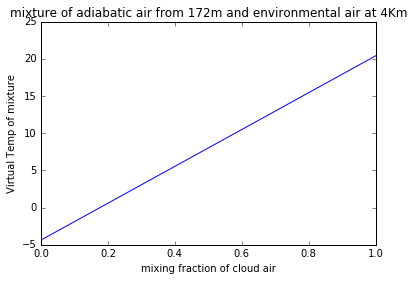

In [102]:
adia_Tv = moist_adiabat_ycoords_interp[0] + c.Tc
env_Tv = 268.786545158 # at 4000m from problem 3

frac = np.linspace(0.,1.,20) #fraction of cloud air (adiabatic air)
mix_Tv = (frac * adia_Tv) + ((1. - frac) * env_Tv) - c.Tc

%matplotlib inline
plt.plot(frac,mix_Tv)
plt.title('mixture of adiabatic air from 172m and environmental air at 4Km')
plt.xlabel('mixing fraction of cloud air')
plt.ylabel('Virtual Temp of mixture')    